In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import pickle
#from scipy.spatial import cKDTree
#from SCTransform import SCTransform


#from nico import Annotations as sann
import Annotations as sann


import warnings
import time
warnings.filterwarnings('ignore')
#export PYTHONWARNINGS='ignore:Multiprocessing-backed parallel loops:UserWarning'
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"



### Usage introduction 
Please download the sample data from the git repository nico_tutorial and keep all the files and folders in
the same directory to complete the tutorial. 

inputRef  (single-cell RNA-sequencing data) 
inputQuery (single-cell resolution spatial transcriptomics data)
NiCoLRdb.txt (Ligand-receptor database file) 

The following notebook normalizes the count data and computes the initial Leiden clustering on the spatial transcriptomics 
data to perform the cell type annotation using NiCo:
Start_Data_preparation_for_niche_analysis.ipynb

Once all the steps of the data preparation notebook are finalized, run the core notebook to perform the full NiCo analysis: 
Perform_spatial_analysis.ipynb


In [2]:
# This is input data path for the scRNA-seq and spatial data 
# If the data is not in h5ad or csv format then please adjust following the standard scanpy routine. 

scdatapath='./inputRef/'
spdatapath='./inputQuery/'

ad_spatial_ori=sc.read(spdatapath+'gene_by_cell.csv').transpose()
ad_seq_ori=sc.read_h5ad(scdatapath+'input_ref.h5ad') 

# This is the coordinate file of the cell centroids from the spatial transcriptomics experiment.  
coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()


In [3]:
# make sure that the order of cells in the count matrix and in the cell location 
#matrix are identical (command should return TRUE); otherwise correct the order

np.array_equal(coordinate[:,0],ad_spatial_ori.obs_names)

True

In [4]:
ad_spatial_ori.obsm['spatial']=coordinate[:,1:].astype(float)

### If spatial h5ad object is already available 
If the user already has spatial data in h5ad format with coordinate information tagged as spatial (.obsm['spatial']), they can skip the above command and directly load the spatial data as follows.

ad_spatial_ori=sc.read_h5ad(spdatapath+'input_query_spatial_data.h5ad')

In [5]:
# data size of the variables 
print(ad_spatial_ori)
print(ad_seq_ori)
print(coordinate.shape)

AnnData object with n_obs × n_vars = 7416 × 241
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2239 × 32287
    obs: 'cluster'
(7416, 4)


In [6]:
# Filter the cells and genes 
sc.pp.filter_cells(ad_spatial_ori, min_counts=5)
sc.pp.filter_cells(ad_seq_ori, min_counts=5)

sc.pp.filter_genes(ad_spatial_ori, min_cells=1)
sc.pp.filter_genes(ad_seq_ori, min_cells=1)

print(ad_spatial_ori)
print(ad_seq_ori)

AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2239 × 21197
    obs: 'cluster', 'n_counts'
    var: 'n_cells'


### Original scRNAseq data 
Copy the scRNA-seq data into new variables as well as into the raw layer 
The Original_count count matrix will be used to derive the UMAP for the scRNA-seq data. 
The raw layer count matrix will be used to find the Spearman and Cosine similarity of genes with the latent factors. 

In [7]:
Original_counts=ad_seq_ori.copy()
Original_counts.raw=Original_counts.copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


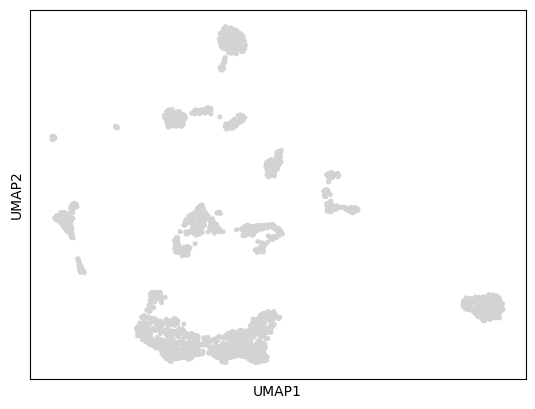

In [8]:
# Standard scanpy analysis 

sc.pp.normalize_total(Original_counts)
sc.pp.log1p(Original_counts)

sc.tl.pca(Original_counts)
sc.pp.neighbors(Original_counts)
sc.tl.umap(Original_counts)
sc.pl.umap(Original_counts)


In [9]:
# save the data 
Original_counts.write_h5ad(scdatapath+'Original_counts.h5ad')

### Find shared genes 
Now find the shared genes between two modalities and subset the matrix to retain only common genes. 

In [10]:
sp_genename=ad_spatial_ori.var_names.to_numpy()
sc_genename=ad_seq_ori.var_names.to_numpy()

index_sp,index_sc=sann.find_index(sp_genename,sc_genename)
#ad_seq_common=ad_seq_ori[:,index_sc].copy()
ad_seq_common=ad_seq_ori.copy()
ad_spatial_common=ad_spatial_ori[:,index_sp].copy()

print(len(sp_genename[index_sp]))
print(len(sc_genename[index_sc]))

203
203


### Perform scTransform like normalization with two different alternative stratgies

In [11]:
# Alternative 1 
# The sctransform normalization function used from scanpy 

'''
ad_seq_common.raw=ad_seq_common.copy()
ad_spatial_common.raw=ad_spatial_common.copy()
# perform scTranform normalization common gene space for spatial data and scRNAseq data  
sc.experimental.pp.normalize_pearson_residuals(ad_seq_common,inplace=True) #ad_seq_common.X[ad_seq_common.X<0]=0

ad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')
sc.experimental.pp.normalize_pearson_residuals(ad_spatial_common,inplace=True) #ad_spatial_common.X[ad_spatial_common.X<0]=0
#print(ad_spatial_common.X.toarray()
'''

"\nad_seq_common.raw=ad_seq_common.copy()\nad_spatial_common.raw=ad_spatial_common.copy()\n# perform scTranform normalization common gene space for spatial data and scRNAseq data  \nsc.experimental.pp.normalize_pearson_residuals(ad_seq_common,inplace=True) #ad_seq_common.X[ad_seq_common.X<0]=0\n\nad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')\nsc.experimental.pp.normalize_pearson_residuals(ad_spatial_common,inplace=True) #ad_spatial_common.X[ad_spatial_common.X<0]=0\n#print(ad_spatial_common.X.toarray()\n"

In [12]:
# Alternative 2
# The normalization function used from external functions 
# In the paper this functions was used

temp_spatial=ad_spatial_common.copy()
temp_seq=ad_seq_common.copy()

sct_ad_sp = sann.SCTransform(ad_spatial_common,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells
                        bin_size=500,bw_adjust=3,inplace=False)

sct_ad_sc = sann.SCTransform(ad_seq_common,min_cells=1,gmean_eps=1,n_genes=500,n_cells=None, #use all cells
		                bin_size=500,bw_adjust=3,inplace=False)

ad_spatial_common=sct_ad_sp.copy()
ad_seq_common=sct_ad_sc.copy()

ad_spatial_common.raw=temp_spatial.copy()
ad_seq_common.raw=temp_seq.copy()
ad_spatial_common.obsm['spatial']= temp_spatial.obsm['spatial']

ad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')

# Perform Leiden clustering on spatial transcriptomics data to guide the NiCo annotations 

In [13]:
# standard scanpy analysis 
sc.pp.pca(ad_spatial_common)
sc.pp.neighbors(ad_spatial_common,n_pcs=30)
sc.tl.umap(ad_spatial_common)

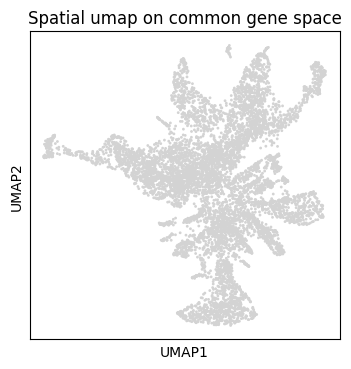

In [14]:
# visualize umap 
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ad_spatial_common, title=["Spatial umap on common gene space"],wspace=0.4,show=True)

### Guiding Leiden cluster resolutions
Peform Leiden clustering for several resolution parameters. 
If it takes a long time to compute, then you can limit the number of parameters. 

Any of the resolution parameters  here can be used as an input parameter (guiding_spatial_cluster_resolution_tag) in the NiCo pipeline

In [15]:
#sc.tl.leiden(ad_spatial_common, resolution=0.3,key_added="leiden0.3")
sc.tl.leiden(ad_spatial_common, resolution=0.4,key_added="leiden0.4")
sc.tl.leiden(ad_spatial_common, resolution=0.5,key_added="leiden0.5")
#sc.tl.leiden(sct_ad_sp, resolution=0.6,key_added="leiden0.6")
#sc.tl.leiden(sct_ad_sp, resolution=0.7,key_added="leiden0.7")
#sc.tl.leiden(sct_ad_sp, resolution=0.8,key_added="leiden0.8")

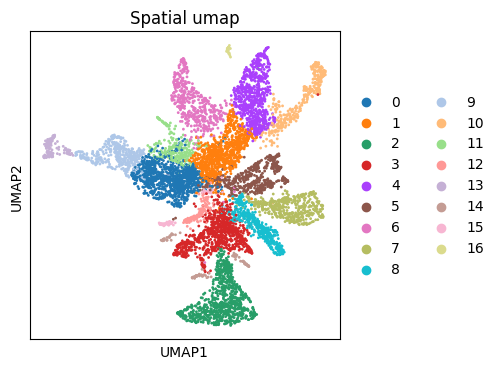

In [16]:
# Visualize your initial spatial clustering in the umap 
# A good resolution parameter should yield clusters corresponding to major cell types.  

sc.pl.umap(ad_spatial_common, color=["leiden0.5"], title=["Spatial umap"],wspace=0.4,
           show=True, save='_spatial_umap.png')

In [17]:
# Save the Leiden clusters for all resolution parameters as well as normalized count data in h5ad format. 
ad_spatial_common.write_h5ad(spdatapath+'sct_spatial.h5ad')